# Setup

## Install Detectron2

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 274 kB 6.2 MB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44074 sha256=2e99655f36b7c6c9d793773ea549adb68cbe6515fd4a9ade21180d4b6917946e
  Stored in directory: /home/shabanza/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.7.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-x8w82efd
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x8w82efd
     |████████

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
torch:  1.10 ; cuda:  cu113
detectron2: 0.6


## Install Mask2Former

In [2]:
# clone and install Mask2Former
# !git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
%pip install -U opencv-python
# %pip install git+https://github.com/cocodataset/panopticapi.git
%pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install

/scratch/shabanza/segmentation/Mask2Former
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 61.7 MB 6.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.3 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 108.1 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 8.1 MB/s s eta 0:00:01
     |████████████████████████████████| 1.3 MB 78.4 MB/s eta 0:00:01
     |████████████████████████████████| 268 kB 96.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
Note: you may need to restart the kernel to use updated packages.
/scratch/shabanza/segmentation/

In [3]:
%cd /scratch/shabanza/segmentation/Mask2Former
%cd mask2former/modeling/pixel_decoder/ops
!sudo sh make.sh
%cd /scratch/shabanza/segmentation/Mask2Former

/scratch/shabanza/segmentation/Mask2Former
/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops
running build
running build_py
running build_ext
building 'MultiScaleDeformableAttention' extension
Emitting ninja build file /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
g++ -pthread -shared -B /opt/conda/compiler_compat -L/opt/conda/lib -Wl,-rpath=/opt/conda/lib -Wl,--no-as-needed -Wl,--sysroot=/ /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/src/vision.o /scratch/shabanza/segmentation/Mask2Former/mask2former/modeling/pixel_decoder/ops/build/temp.linux-x86_64-3.8/scratch/shabanza/segment

For gccxx not found error:
> sudo apt-get update && sudo apt-get install software-properties-common && sudo add-apt-repository ppa:ubuntu-toolchain-r/test && sudo apt-get upgrade libstdc++6

For libGL error:
> sudo apt-get install ffmpeg libsm6 libxext6  -y

## Imports

In [1]:
# import some common libraries
import torch
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
torch.cuda.empty_cache()

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# %cd Mask2Former
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# Dataset

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from src.dataset.register_comic_instance import *

registering comic ...
loading sinergia json ...
Sinergia Json loaded.
registering placid ...


100%|██████████| 47256/47256 [00:00<00:00, 722322.55it/s]


registering yves ...


100%|██████████| 47256/47256 [00:00<00:00, 738464.29it/s]


In [6]:
dataset_name = DATASET_NAME

dataset_dicts = DatasetCatalog.get(dataset_name)
metadata = MetadataCatalog.get(dataset_name)

[09/20 10:44:37 d2.data.datasets.coco]: Loading /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_default_modified.json takes 1.47 seconds.
[09/20 10:44:37 d2.data.datasets.coco]: Loaded 282 images in COCO format from /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_default_modified.json


In [7]:
placid_dataset_dicts = DatasetCatalog.get(PLACID_NAME)
placid_metadata = MetadataCatalog.get(PLACID_NAME)

[09/20 10:44:38 d2.data.datasets.coco]: Loaded 154 images in COCO format from /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_placid.json


In [8]:
yves_dataset_dicts = DatasetCatalog.get(YVES_NAME)
yves_metadata = MetadataCatalog.get(YVES_NAME)

[09/20 10:44:40 d2.data.datasets.coco]: Loading /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_yves.json takes 1.92 seconds.
[09/20 10:44:40 d2.data.datasets.coco]: Loaded 128 images in COCO format from /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_yves.json


# Finetune

In [9]:
from src.evaluation.instance_evaluation import *
from src.evaluation.semantic_evaluation import *
from src.evaluation.helpers import *
from src.dataset.register_train_test import *
from src.dataset.helpers import *
from src.train.config import *
from src.train.mask2former_trainer import *

## Placid

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
class Args:
    def __init__(self) -> None:
        self.lr = 7e-5
        self.num_gpus = 1
        self.test_size = 0.2
        self.random_state = 42
        self.eval_type = EvalType.COMIC_SEM_SEG.value
        self.data_mode = 'placid'
        self.fn_mode = 'queryfeat'
        self.batch_size = 16
        self.cropped = True
        self.epochs = 10
        self.keep_class_ids = [24, 25, 26, 27]
        self.config_file = 'Mask2Former/configs/coco/instance-segmentation/swin/maskformer2_swin_large_IN21k_384_bs16_100ep.yaml'
        self.opts = ['SOLVER.CHECKPOINT_PERIOD', '1000',
                'MODEL.WEIGHTS', 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_e5f453.pkl', 
                'OUTPUT_DIR', '/sinergia/shabanza/outputs/coco']

args = Args()
cfg = mask2former_setup(args)

sinergia_placid_instances
registering train test dataset ...
[09/20 13:15:16 d2.data.datasets.coco]: Loaded 154 images in COCO format from /sinergia/shabanza/datasets/sinergia/coco/annotations/instances_placid.json
sinergia_placid_instances_train 123
sinergia_placid_instances_train_cropped already registered...!
sinergia_placid_instances_test 31
sinergia_placid_instances_test_cropped already registered...!
LR is:  7e-05
MAX ITER is:  15
STEPS is:  (655556, 710184)


In [ ]:
trainer = Mask2FormerComicTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# if args.wandb:
histories = trainer.storage.histories()


In [ ]:
# cfg.DATASETS.TRAIN = (YVES_NAME, )
# build_detection_train_loader(
#     cfg, mapper=ComicDatasetMapper(is_train=True), 
# )

[09/04 16:18:42 d2.data.datasets.coco]: Loading /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_yves.json takes 1.39 seconds.
[09/04 16:18:43 d2.data.datasets.coco]: Loaded 128 images in COCO format from /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_yves.json
[09/04 16:18:43 d2.data.build]: Removed 1 images with no usable annotations. 127 images left.
[09/04 16:18:43 d2.data.build]: Distribution of instances among all 28 categories:
|   category    | #instances   |   category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:----------:|:-------------|
| Generic Obj.. | 1571         |     Car      | 0            |    Bus     | 0            |
|    Bicycle    | 0            |  Motorbike   | 0            |  Airplane  | 0            |
|     Boat      | 56           |    Train     | 0            |   Chair    | 48           |
|     Sofa      | 16        

In [13]:
# cfg.DATASETS.TRAIN = (PLACID_NAME, )
# build_detection_train_loader(
#     cfg, mapper=ComicDatasetMapper(is_train=True), 
# )

[09/04 16:18:54 d2.data.datasets.coco]: Loaded 154 images in COCO format from /home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_placid.json
[09/04 16:18:56 d2.data.build]: Removed 0 images with no usable annotations. 154 images left.
[09/04 16:18:56 d2.data.build]: Distribution of instances among all 28 categories:
|   category    | #instances   |   category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:----------:|:-------------|
| Generic Obj.. | 3381         |     Car      | 130          |    Bus     | 3            |
|    Bicycle    | 30           |  Motorbike   | 28           |  Airplane  | 34           |
|     Boat      | 43           |    Train     | 1            |   Chair    | 131          |
|     Sofa      | 62           |    Table     | 117          |   Plant    | 839          |
|      Cat      | 76           |     Dog      | 113          |    Cow     | 18           |
|     Hor

In [14]:
cfg.KEEP_CLASS_IDS = None
data_loader = Mask2FormerComicTrainer.build_train_loader(cfg)

[09/20 10:45:26 d2.data.build]: Removed 0 images with no usable annotations. 25 images left.
[09/20 10:45:26 d2.data.build]: Distribution of instances among all 28 categories:
|   category    | #instances   |   category   | #instances   |  category  | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:----------:|:-------------|
| Generic Obj.. | 39           |     Car      | 0            |    Bus     | 0            |
|    Bicycle    | 0            |  Motorbike   | 0            |  Airplane  | 0            |
|     Boat      | 0            |    Train     | 0            |   Chair    | 0            |
|     Sofa      | 0            |    Table     | 0            |   Plant    | 4            |
|      Cat      | 0            |     Dog      | 0            |    Cow     | 0            |
|     Horse     | 0            |    Sheep     | 0            |    Bird    | 1            |
| Generic Ani.. | 0            |   Building   | 5            | Background | 0            |
|    

In [78]:
cfg.MODEL.WEIGHTS = '/sinergia/shabanza/outputs/coco/model_final.pth'
predictor = ComicPredictor(cfg)

[09/20 13:09:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /sinergia/shabanza/outputs/coco/model_final.pth ...


In [91]:
predictor2 = ComicPredictor(cfg)

[09/20 13:15:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/maskformer2_swin_large_IN21k_384_bs16_100ep/model_final_e5f453.pkl ...


Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...
Skip loading parameter 'sem_seg_head.predictor.class_embed.weight' to the model due to incompatible shapes: (81, 256) in the checkpoint but (29, 256) in the model! You might want to double check if this is expected.
Skip loading parameter 'sem_seg_head.predictor.class_embed.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (29,) in the model! You might want to double check if this is expected.
Skip loading parameter 'criterion.empty_weight' to the model due to incompatible shapes: (81,) in the checkpoint but (29,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
criterion.empty_weight
sem_seg_head.predictor.class_embed.{bias, weight}


In [31]:
sum(p.numel() for p in predictor.model.parameters())

215508625

In [33]:
test_loader = Mask2FormerComicTrainer.build_test_loader(cfg, cfg.DATASETS.TEST[0])

In [48]:
b = next(iter(test_loader))

/opt/conda/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63975d7a60>
  self.pid = os.fork()
/opt/conda/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63975d7a60>
  self.pid = os.fork()


In [85]:
# im = b[0]['image'].cpu().numpy().transpose((1, 2, 0))
im = cv2.imread('images/placid-panel1.png')
pred_output = predictor(im)

/scratch/shabanza/segmentation/Mask2Former/mask2former/maskformer_model.py:372: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_indices = topk_indices // self.sem_seg_head.num_classes


In [92]:
pred_output = predictor2(im)

/scratch/shabanza/segmentation/Mask2Former/mask2former/maskformer_model.py:372: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_indices = topk_indices // self.sem_seg_head.num_classes


In [38]:
comic_metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
comic_metadata.stuff_classes = []

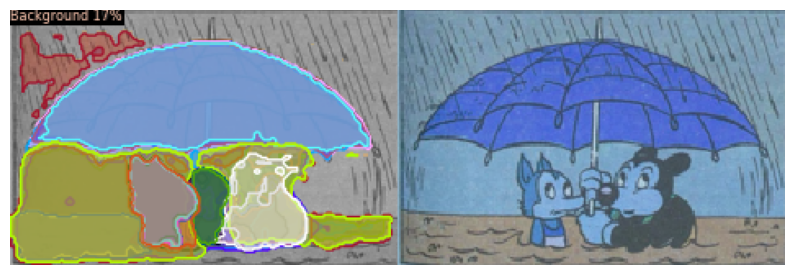

In [93]:
# im = b[0]['image'].cpu().numpy().transpose((1, 2, 0))
v = Visualizer(im[:, :, ::-1], comic_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(pred_output["instances"].to("cpu")).get_image()
v = Visualizer(im, comic_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(pred_output["sem_seg"].argmax(0).to("cpu")).get_image()
res = np.concatenate((instance_result, semantic_result), axis=1)
plt.figure(figsize=(10, 8))
plt.imshow(res)
plt.axis('off')
plt.show()

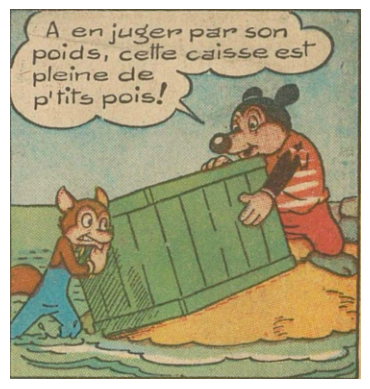

In [54]:
plt.imshow(im)
plt.axis('off')
plt.show()

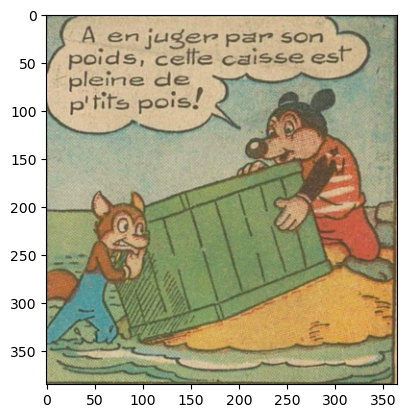

Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)


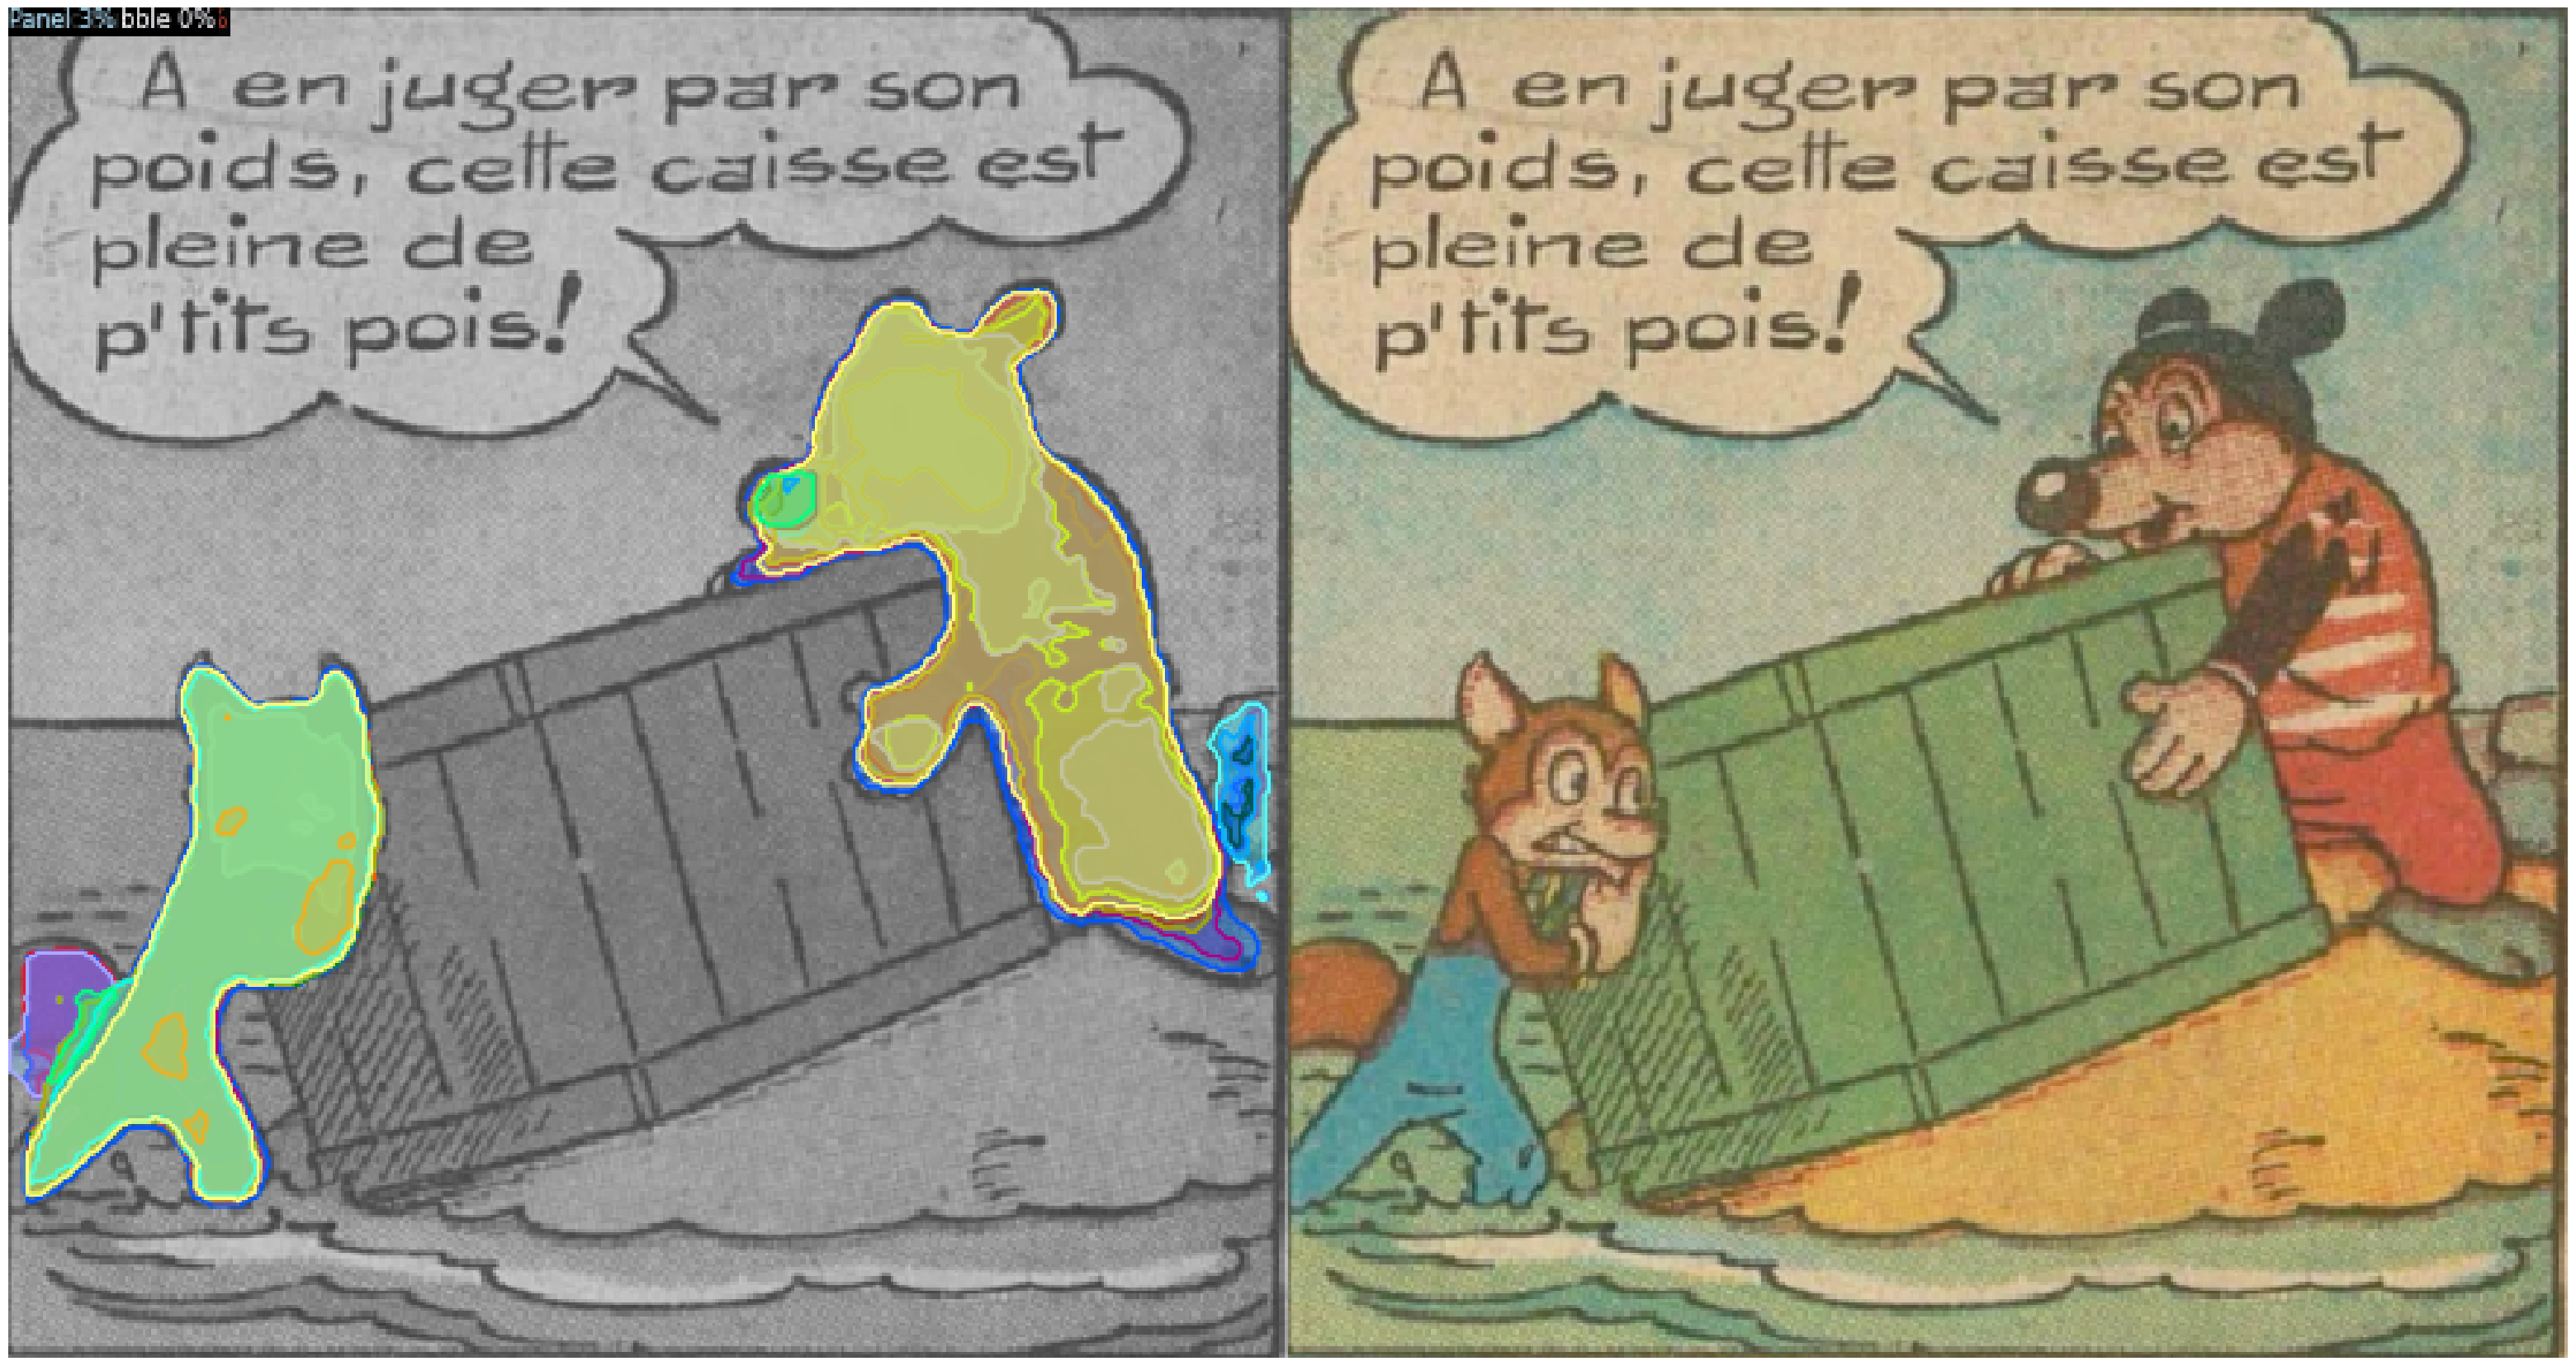

In [50]:
from src.dataset.helpers import *

im = b[0]['image'].cpu().numpy().transpose((1, 2, 0))
plt.imshow(im)
plt.show()
v = Visualizer(im[:, :, ::-1], comic_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(pred_output["instances"].to("cpu")).get_image()
v = Visualizer(im, comic_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(pred_output["sem_seg"].argmax(0).to("cpu")).get_image()
print("Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)")
res = np.concatenate((instance_result, semantic_result), axis=1)
plt.figure(figsize=(40, 30))
plt.imshow(res)
plt.axis('off')
plt.show()

/opt/conda/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63975d7a60>
  self.pid = os.fork()
/opt/conda/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63975d7a60>
  self.pid = os.fork()


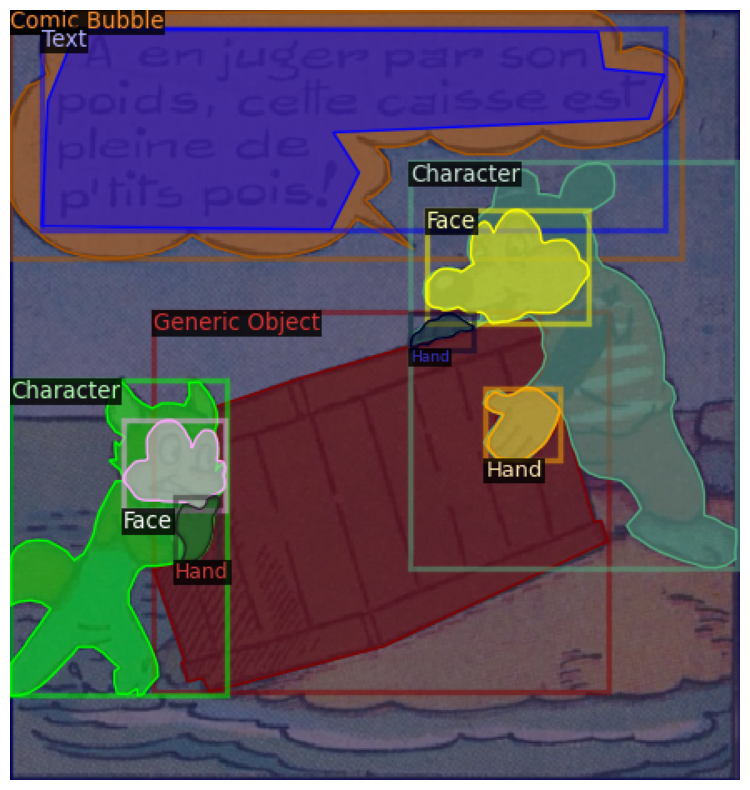

In [41]:
b = next(iter(test_loader))
im = b[0]['image'].cpu().numpy().transpose((1, 2, 0))
v = Visualizer(im, placid_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
r = v.draw_dataset_dict(b[0]).get_image()
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(r)

In [25]:
b = next(iter(test_loader))

In [35]:
MetadataCatalog.get(cfg.DATASETS.TEST[0])

namespace(name='sinergia_placid_instances_test',
          json_file='/home/yalda/IVRL_backup/shabanza_sinergia/datasets/sinergia/coco/annotations/instances_placid.json',
          evaluator_type=<EvalType.COMIC_SEM_SEG: 'comic_sem_seg'>,
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             12: 11,
                                             13: 12,
                                             14: 13,
                                      

In [32]:
import random

sample = random.choice(placid_dataset_dicts)

In [36]:
from src.dataset.dataset_mapper import image2tensor_mapper


sample_panels = panel_mapper(sample)

In [48]:
model.eval()
outputs = model([panel])[0]

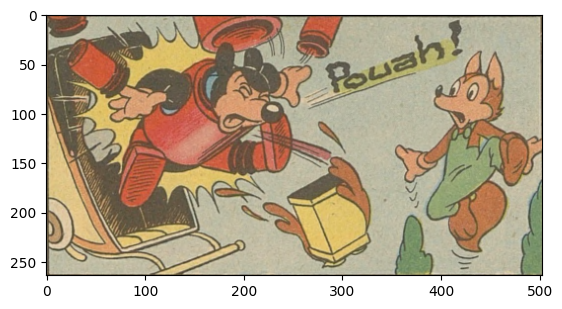

In [58]:
plt.imshow(im)

Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)


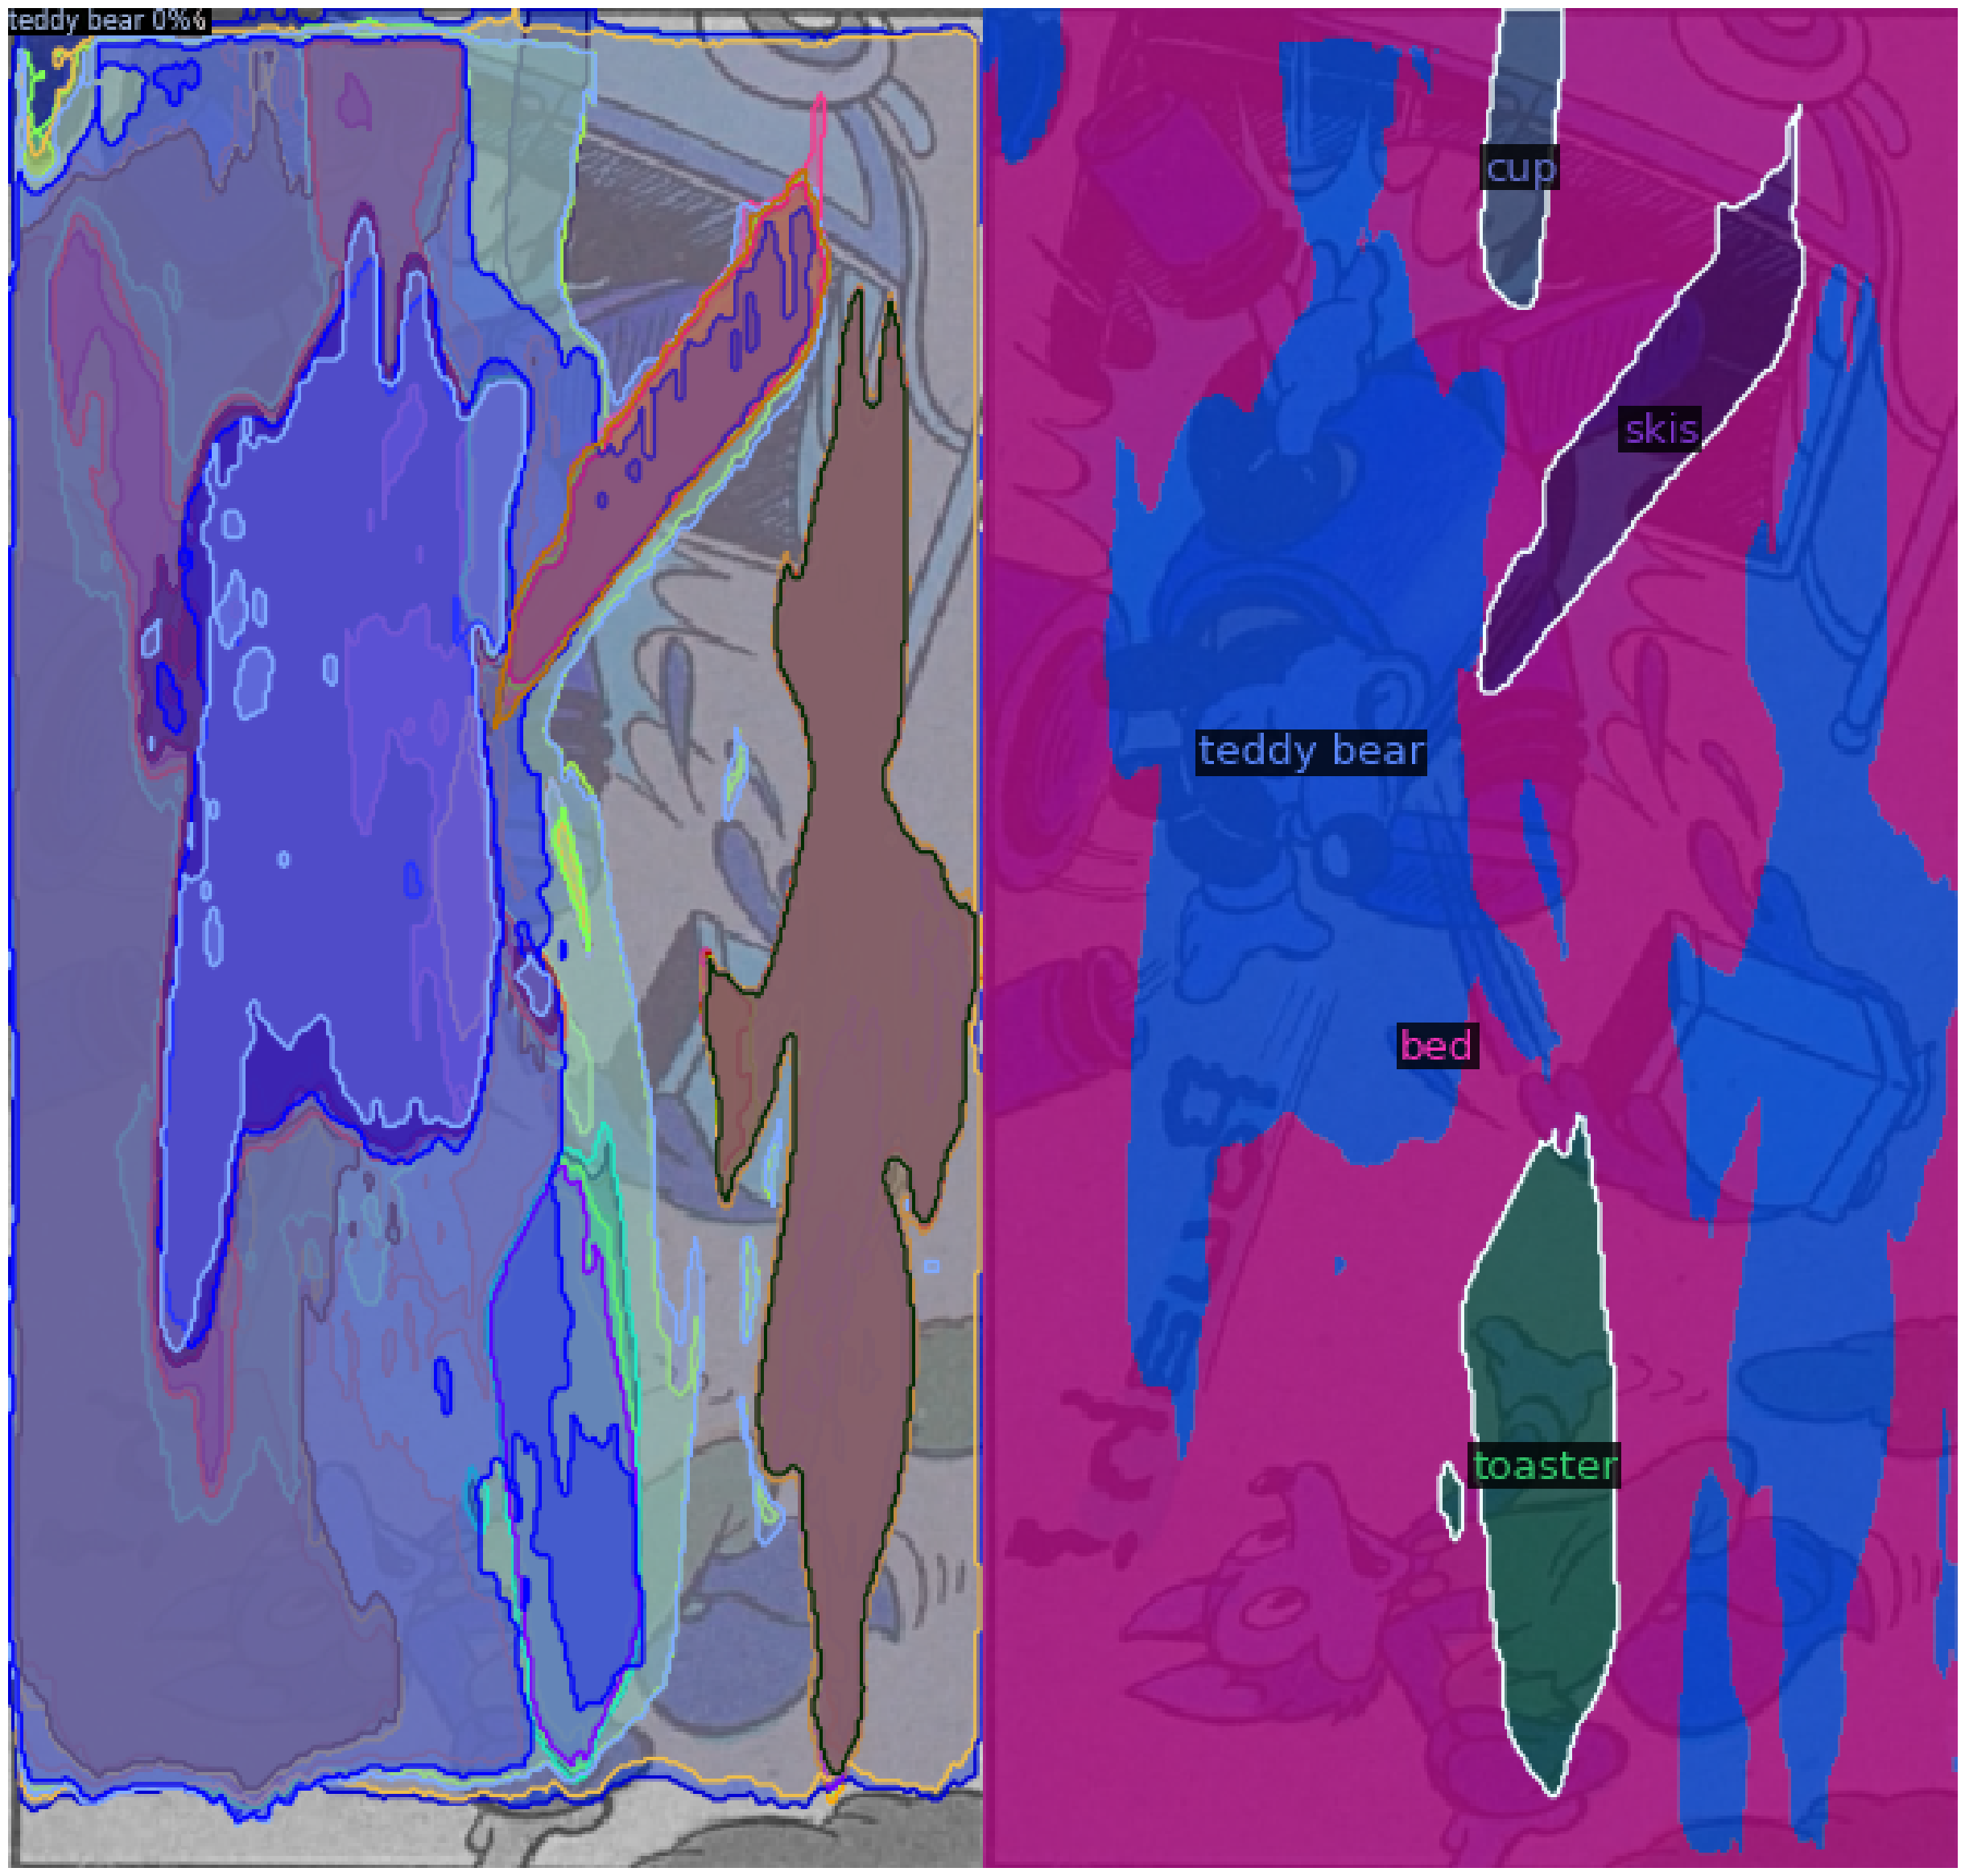

In [59]:
from src.dataset.helpers import *
im = panel['image'].cpu().numpy().transpose(2, 1, 0)

v = Visualizer(im, coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
v = Visualizer(im, coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
semantic_result = v.draw_sem_seg(outputs["sem_seg"].argmax(0).to("cpu")).get_image()
print("Panoptic segmentation (top), instance segmentation (middle), semantic segmentation (bottom)")
res = np.concatenate((instance_result, semantic_result), axis=1)[:, :, ::-1]
plt.figure(figsize=(40, 30))
plt.imshow(res)
plt.axis('off')
plt.show()